In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
import math
import os
import time
import pdb
import numbers

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions, four_rooms_grid
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ
from anytree import Node, PreOrderIter
from anytree.search import findall_by_attr
from anytree.render import RenderTree

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
twoRooms_grid = two_rooms_grid(room_width=10, room_height=7, doorway_pos=3, doorway_height=1, goal_height=0)

# Declaring reset density
reset_density = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
for i in range(reset_density.shape[0]):
    for j in range(reset_density.shape[1]):
        if twoRooms_grid[i][j] != 'x' and 'x' in twoRooms_grid[i][j:]:
            reset_density[i][j] = 1
reset_density /= reset_density.sum()

def static_filter(s,dist_to_goal=4):
    objective = np.array([0,len(twoRooms_grid[0])-1])
    coord_s = np.array(twoRooms.state2coord[s])
    return np.linalg.norm(objective-coord_s) >= dist_to_goal

twoRooms = GridWorld(gamma=0.95, static_filter=static_filter, grid=twoRooms_grid, reset_density=reset_density)

fourRooms_grid = four_rooms_grid(room_width=10, room_height=7, doorway_pos_v=5, doorway_pos_h=3, doorway_height=1, goal_width=20, goal_height=12)
fourRooms = GridWorld(gamma=0.95, static_filter=static_filter, grid=fourRooms_grid)

## Value estimation in RL

Let's define a first policy that we will test the problem with:

In [3]:
def policy1(state,GridWorld):
    if 0 in GridWorld.state_actions[state]:
        action = 0
    elif 3 in GridWorld.state_actions[state]:
        action = 3
    elif 1 in GridWorld.state_actions[state]:
        action = 1
    else:
        action = 2
    return action    

In [4]:
Q4_ValEst = ValueLearning(1,twoRooms,policy1)
Q4_ValEst.run()
Q4_ValEst.render()

## Policy learning in RL

Stats from last run
Mean reward cumulated over single episode: 500.50


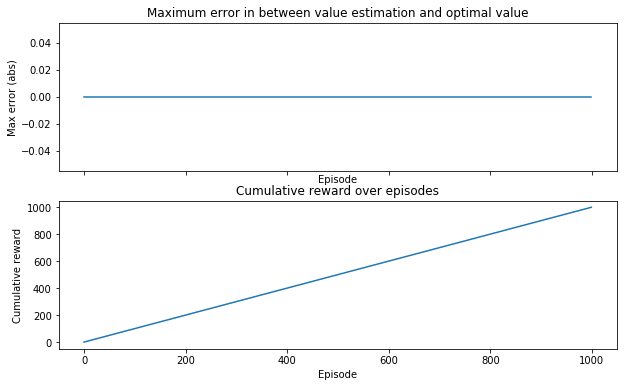

In [5]:
P = PolicyLearning(ind=0, GridWorld=twoRooms, max_iter = 1000)
P.run()
P.stats()
P.render()

gui.render_policy(P.GridWorld, P.policy)

## Hierarchical RL
### MAXQ Algorithm

We will build an option $O_{downward}$ with the following characteristics:
- non-zero probability of being triggered everywhere in the left room, above the doorway
- null probability of being triggered everywhere in the right room
- when triggered, moves downward until it reaches the level of doorway, then moves right towards it
- stops when reaching the grid element just in front of the door from the left room to the right room

Similarly, we will build the $O_{upward}$ that is exactly symmetrical of $O_{downward}$, allowing to reach the doorway from every element in the lower part of the left room.

In [3]:
[downward_initSet,upward_initSet, quitMap, downward_policy_matrix, upward_policy_matrix] = two_rooms_computeOptions(room_width=10, room_height=7, doorway_pos=3, doorway_height=1)

def downward_policy(coords):
    return downward_policy_matrix[coords[0],coords[1]]
def upward_policy(coords):
    return upward_policy_matrix[coords[0],coords[1]]

downward_option = Option(downward_initSet, downward_policy, quitMap, conceptState=70, name='Downward to doorway')
upward_option = Option(upward_initSet, upward_policy, quitMap, conceptState=70, name='Upward to doorway')

# print(downward_policy_matrix)
# print(upward_policy_matrix)
# print(downward_initSet)
# print(upward_initSet)
# print(quitMap)

In [4]:
MaxQ_2Rooms = MAXQ(twoRooms, expl0=0, n_iter=1000, optionSet=[downward_option, upward_option], debug=False)

Training MAXQ on 1000 runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Root
├── right
├── down
├── left
├── up
├── Downward to doorway
│   ├── right
│   ├── down
│   ├── left
│   └── up
└── Upward to doorway
    ├── right
    ├── down
    ├── left
    └── up


Training MAXQ on 1000 runs: 100%|██████████| 1000/1000 [00:09<00:00, 105.39it/s]


In [10]:
pdb.pm()

> /home/proprietaire/Documents/Workspace/School/MVA/ReinforcementLearning/Project/Git/RLProject/HRL_methods.py(210)explorationPolicy()
-> if failed or np.isnan(greedyActionID):
(Pdb) self
(Pdb) self.state
*** AttributeError: 'MAXQ' object has no attribute 'state'
(Pdb) state
7
(Pdb) self.GridWorld.state2coord[7]
[0, 7]
(Pdb) Q
array([[ 0.,  0.,  0., -1.,  1., -1.]])
(Pdb) c


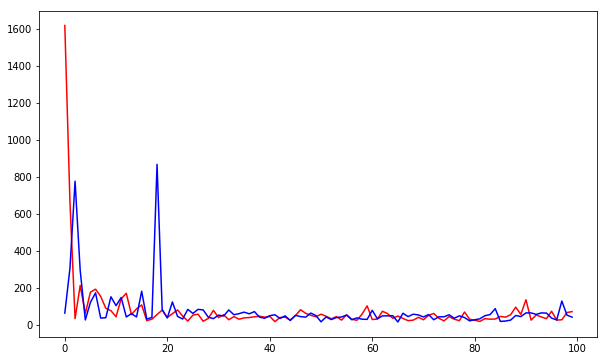

In [9]:
# plt.plot(range(max(MaxQ_2Rooms.n_iter, P.max_iter)), MaxQ_2Rooms.timeLog, 'r', range(max(MaxQ_2Rooms.n_iter, P.max_iter)), P.timeLog, 'b')
plt.plot(range(100), MaxQ_2Rooms.timeLog[:100], 'r', range(100), P.timeLog[:100], 'b')

In [ ]:
print(np.argwhere(array(twoRooms.grid) == '1').ravel())
print(np.array(twoRooms.state2coord[40]))

In [ ]:
np.linalg.norm([3,3] - np.array(twoRooms.state2coord)[[45,62,12,31,2,78,94]], axis=1) > 5

In [11]:
def get_DD_map(record_trajectory, static_filter = lambda x: True):
    
    DD_map = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
    count = {}
    for s in range(twoRooms.n_states):
        count[s] = 0
    for traj in record_trajectory:
        seen = {}
        for x,_,_ in traj:
            if not x in seen and static_filter(x):
                i,j = twoRooms.state2coord[x]
                DD_map[i,j] += 1
                seen[x] = True
    
    return DD_map

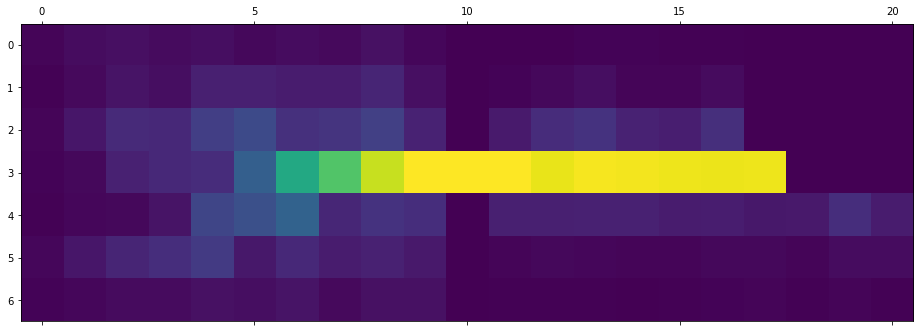

In [12]:
DD_map_RL = get_DD_map(P.trajLog, static_filter)
plt.matshow(DD_map_RL)
plt.show()

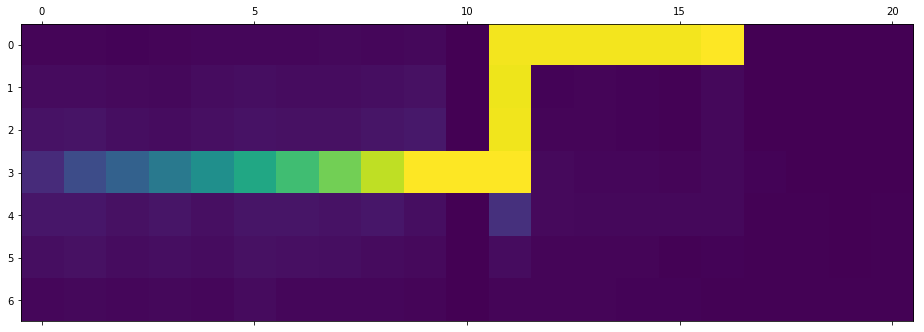

In [13]:
DD_map_HRL = get_DD_map(MaxQ_2Rooms.trajLog, static_filter)
plt.matshow(DD_map_HRL)
plt.show()

In [12]:
print(MaxQ_2Rooms.lastTraj)

[]


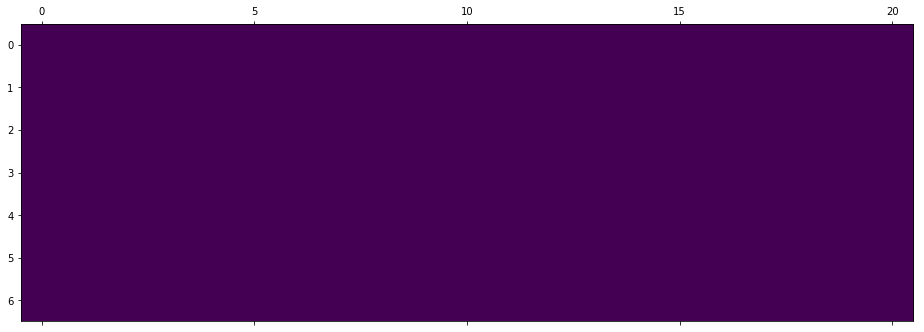

In [13]:
DD_map_HRL_Last = get_DD_map([MaxQ_2Rooms.lastTraj], static_filter)
plt.matshow(DD_map_HRL_Last)
plt.show()

In [16]:
print(DD_map_HRL)

[[  618.   681.   707.   722.   752.   769.   783.   771.   736.   662.
      0.    76.   235.   854.   867.   921.   984.     0.     0.     0.
      0.]
 [  666.   702.   749.   765.   798.   810.   823.   825.   797.   734.
      0.   278.   793.   831.   157.   224.   167.     0.     0.     0.
      0.]
 [  685.   724.   765.   788.   815.   825.   835.   868.   853.   810.
      0.   287.   766.   253.    48.    71.   100.     0.     0.     0.
      0.]
 [  689.   730.   760.   791.   813.   836.   849.   865.   898.  1000.
   1000.  1000.   821.   152.    76.    85.    87.    12.     0.     0.
      0.]
 [  682.   715.   757.   781.   807.   820.   838.   852.   856.   823.
      0.   190.   236.   114.    72.    47.    40.    16.    15.    13.
      4.]
 [  658.   712.   734.   767.   791.   810.   824.   815.   787.   746.
      0.   110.   123.    87.    53.    43.    30.    13.     9.     6.
      4.]
 [  614.   672.   703.   735.   757.   756.   781.   763.   721.   666.
    

In [14]:
print(np.array(MaxQ_2Rooms.policy))

[4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 0 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 0
 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5
 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0]


In [15]:
print(np.array(MaxQ_2Rooms.C[0,:,5]))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [16]:
print(np.array(MaxQ_2Rooms.Q))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.